In [2]:
import tensorflow as tf
from tensorflow import keras 
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
from datetime import datetime 

In [3]:
# suppress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
df = pd.read_csv("commodity_historical.csv")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   780 non-null    object 
 1   Crude Oil Brent Price  780 non-null    float64
 2   Cocoa Price            780 non-null    float64
 3   Gold Price             780 non-null    float64
dtypes: float64(3), object(1)
memory usage: 24.5+ KB


In [5]:
data = df[["date", "Cocoa Price"]]
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         780 non-null    object 
 1   Cocoa Price  780 non-null    float64
dtypes: float64(1), object(1)
memory usage: 12.3+ KB


In [6]:
data['date'] = pd.to_datetime(data['date'])

/var/folders/rd/tqc_535n6bb2mkqrf4_7nf6w0000gn/T/ipykernel_87128/736794659.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])


In [7]:
data = data[data["date"] >= "1980-01-01"]  # instead of 1960 which is statistically insignificant

In [8]:
import plotly.express as px
import plotly.graph_objects as go


def plotting(title, data, x, y, x_label, y_label, text=False, lam=None):
    """General function to plot the data."""
    fig = px.line(data, x=data[x], y=data[y], labels={x: x_label, y: y_label})
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title, width=650, title_x=0.5, height=400)
    if text:
      fig.add_annotation(
          x='1952-12-20', y=10, text=f'Lambda = {lam:.3f}',
          align='left', yanchor='bottom', showarrow=False,
          font=dict(size=20, color="black", family="Courier New, monospace"),
          bordercolor='black', borderwidth=2, bgcolor="white"
      )
    fig.show()


def add_separator(width=650):
    """Add a horizontal line as a separator."""
    fig = go.Figure()
    fig.add_hline(y=0.5, line_dash="dot", line_color="gray", line_width=2)
    fig.update_layout(height=50, width=width, margin=dict(l=20, r=20, t=20, b=20), xaxis_visible=False, yaxis_visible=False)
    fig.show()


In [9]:
plotting(title='Cocoa Over Time', data=data, x='date', y='Cocoa Price', x_label='Date', y_label='Price ()')
# add_separator()

In [10]:
len(data)

540

In [11]:
train = data.iloc[:528]  # 1980 to 2023
test = data.iloc[528:]  # 2024

In [12]:
# scaler = StandardScaler()
scaler = MinMaxScaler()
# scaled_data = scaler.fit_transform(data["Crude Oil Brent Price"])
scaler.fit(train[["Cocoa Price"]])
scaled_train = scaler.transform(train[["Cocoa Price"]])
scaled_test = scaler.transform(test[["Cocoa Price"]])

In [13]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Define Parameters
lookback = 3  # Number of past steps to use as input
batch_size = 2  # Number of samples per batch
n_features = 1

# Initialize Generator
generator = TimeseriesGenerator(scaled_train, scaled_train, length=lookback, batch_size=batch_size)

In [14]:
# Build model
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(lookback, n_features)),  # 1st layer
    tf.keras.layers.LSTM(64, return_sequences=False),  # 2nd layer
    tf.keras.layers.Dense(128, activation="relu"),  # 3rd Layer (Dense)
    tf.keras.layers.Dropout(0.2),  # 4th Layer (Dropout)
    tf.keras.layers.Dense(1)  # Final Output Layer
])

# model summary
model.summary()

/opt/anaconda3/envs/ML/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 3, 64)          │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(
    optimizer="adam", 
    loss="mse", 
    metrics=["MeanAbsolutePercentageError"]
)

In [16]:
# fit model
model.fit(generator, epochs=50)

Epoch 1/50


/opt/anaconda3/envs/ML/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 952us/step - MeanAbsolutePercentageError: 510596.7188 - loss: 0.0412
Epoch 2/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - MeanAbsolutePercentageError: 1360.4236 - loss: 0.0048
Epoch 3/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - MeanAbsolutePercentageError: 179942.7344 - loss: 0.0050
Epoch 4/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - MeanAbsolutePercentageError: 42404.9453 - loss: 0.0066
Epoch 5/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - MeanAbsolutePercentageError: 60625.9609 - loss: 0.0049
Epoch 6/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - MeanAbsolutePercentageError: 93394.4766 - loss: 0.0037
Epoch 7/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - MeanAbsolutePercentageError: 97095.6875 - loss: 0.0042
Epoch 8/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - MeanAbsolutePercentageError: 189362.5000 - loss: 0.0041
Epoch 9/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - MeanAbsolutePercentageError: 8937.4980 - loss: 0.0033
Epoch 10/50
2

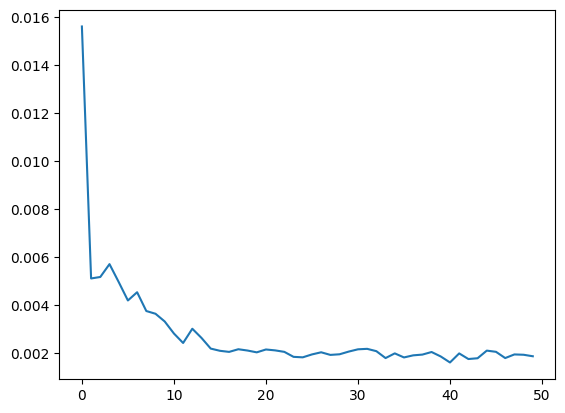

In [17]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [18]:
test_predictions = []

first_eval_batch = scaled_train[-lookback:]
current_batch = first_eval_batch.reshape((1, lookback, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [19]:
def plot_forecasts(df: pd.DataFrame, forecasts: np.ndarray, col: str, title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    
    # Plot true values
    fig.add_trace(go.Scatter(x=df['date'], y=df[col], name='Truth', mode='lines'))
    
    # Plot predicted values
    fig.add_trace(go.Scatter(x=df['date'], y=forecasts.flatten(), name='Prediction', mode='lines'))
    
    fig.update_layout(
        template="simple_white", font=dict(size=18), title_text=title,
        width=650, title_x=0.5, height=400, xaxis_title='Date', yaxis_title='Price'
    )
    
    fig.show()

In [20]:
# Ensure test predictions is a 2D NumPy array before inverse scaling
true_predictions = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))

# Extract correct test set dates
test_dates = data['date'].iloc[len(train):]

In [21]:
plot_forecasts(
    pd.DataFrame({
        'date': test_dates, 
        "Cocoa Price": test["Cocoa Price"].values
    }), 
    true_predictions, 
    "Cocoa Price", 
    "LSTM Forecast for Cocoa"
)

In [22]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Cocoa Price'], true_predictions))
rmse

4.655419494112669

In [23]:
model.save("cocoa_lstm_model.keras")